In [119]:
import pypyodbc as odbc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
import matplotlib.pyplot as plt

In [120]:
DRIVER_NAME = "SQL Server"
SERVER_NAME = "DESKTOP-PJBN9BQ\\SQLEXPRESS"
DATABASE_NAME = "Diabetes"

CONNECTION_STRING = f"""
    DRIVER={{{DRIVER_NAME}}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE_NAME};
    Trust_Connection=yes;
"""

Conn = odbc.connect(CONNECTION_STRING)

In [121]:
cursor = Conn.cursor()

table_name_balanced = "diabetes_binary_split_health_indicators_BRFSS2015"
talbe_name_not_balanced = "diabetes_data_not_balanced"

# Columns to be extraced from SQL server
chosen = '"Diabetes_binary","HighBP","HighChol","BMI","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity","HvyAlcoholConsump","GenHlth","DiffWalk","Sex","Age","Education","Income"'



In [122]:
# Function that creates Dataframe out of given table name
def Create_Dataframe(table_name):
    # SQL query expression 
    query = "SELECT {} FROM {}".format(chosen, table_name) 

    # Creating and featching all the data from given tables
    cursor.execute(query)
    columns = [column[0] for column in cursor.description]
    columns[0] = "diabetes"

    # fetching all data from database
    table = cursor.fetchall()

    # Casting tables to dataframes
    dataframe = pd.DataFrame(table, columns= columns)
    
    # Changing type of data in tables to float
    for column in columns:
        dataframe[str(column)] = dataframe[str(column)].astype(float)
    
    return dataframe

In [123]:
dataframe = Create_Dataframe(table_name= table_name_balanced)

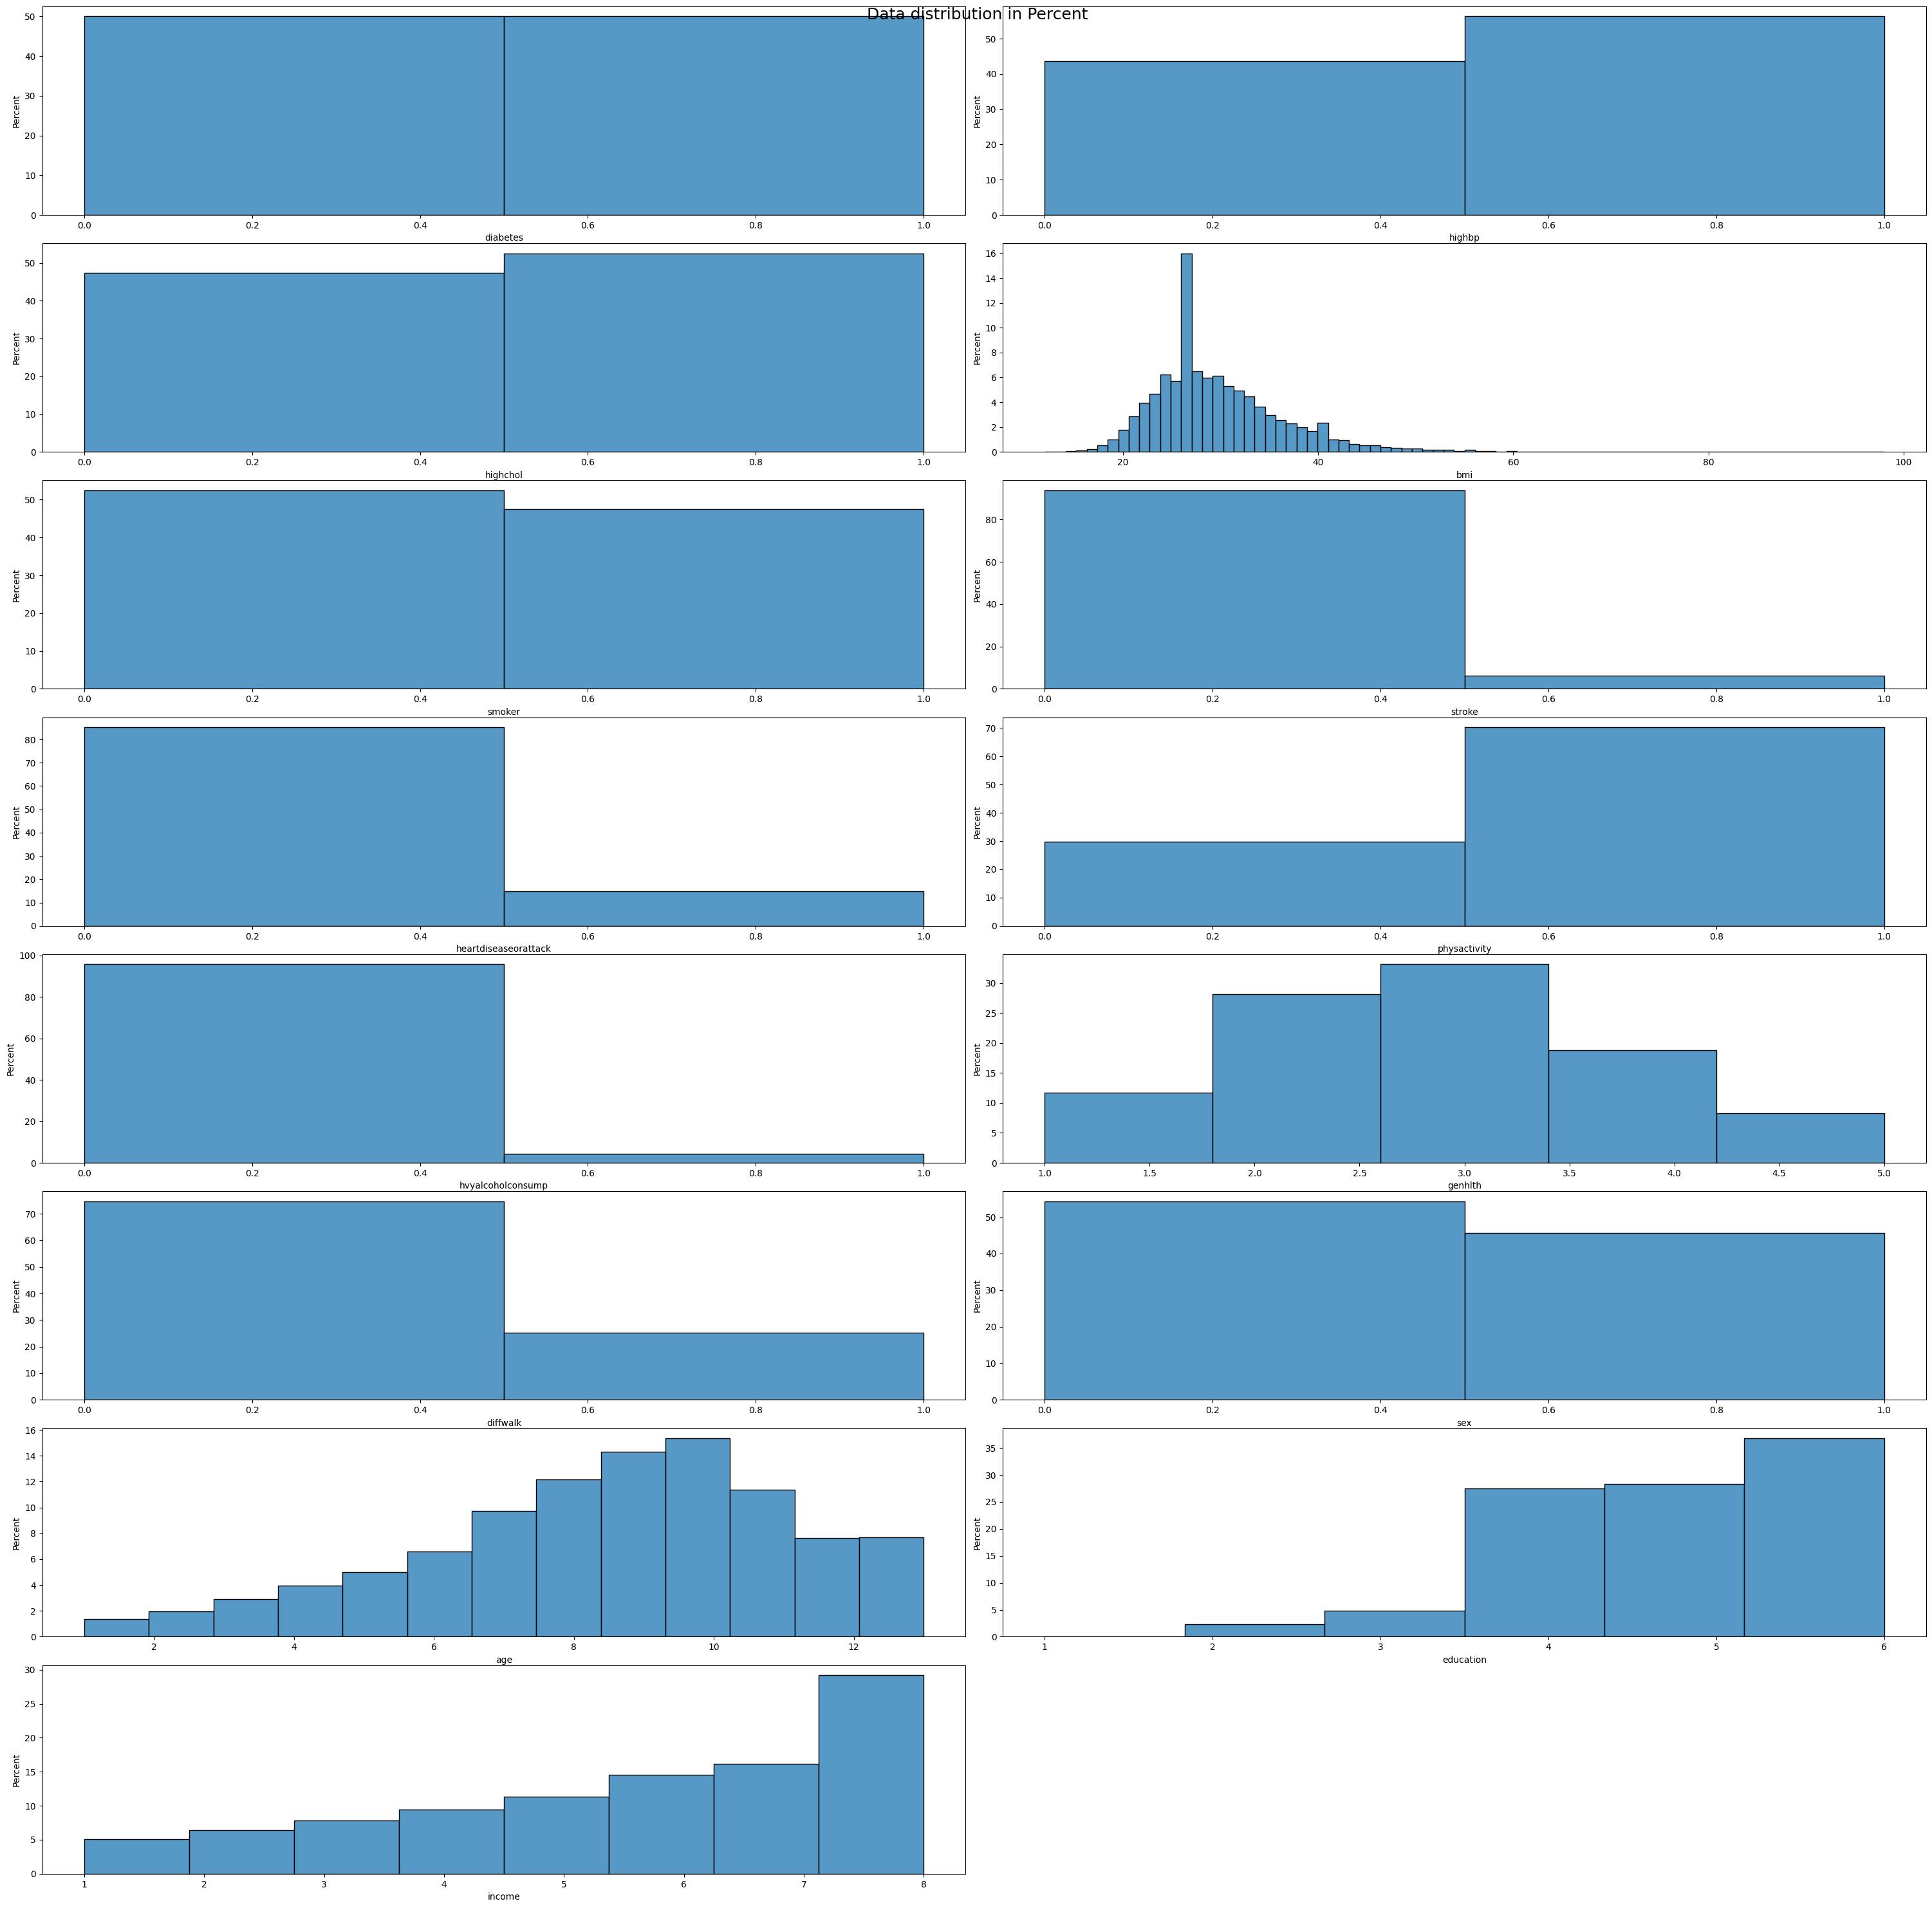

In [124]:
def Data_Distribution(dataframe):
    columns = dataframe.columns
    fig, axs = plt.subplots(len(columns)// 2 + len(columns) % 2,2, figsize = (30,30))
    fig.suptitle('Data distribution in Percent', fontsize=18)
    fig.tight_layout()
    index = 0
    for i in range(0, len(columns)// 2+ len(columns) % 2):
        for j in range(0, 2):
            if (index < len(columns)):
                # Cosmetic
                min_value = dataframe[str(columns[index])].min()
                max_value = dataframe[str(columns[index])].max()
                width_value = max_value - min_value
                bins_amount =  len(set(dataframe[str(columns[index])]))
                bin_width = width_value/ bins_amount
                
                sns.histplot(data = dataframe[str(columns[index])], ax = axs[i, j] ,multiple="stack", stat = "percent", bins = bins_amount, binwidth= bin_width, )
                axs[i,j].set_xlabel(str(columns[index]))
            else:
                axs[i,j].remove()
            index += 1
Data_Distribution(dataframe = dataframe)

Text(0.5, 1.0, 'Heatmap of correlations')

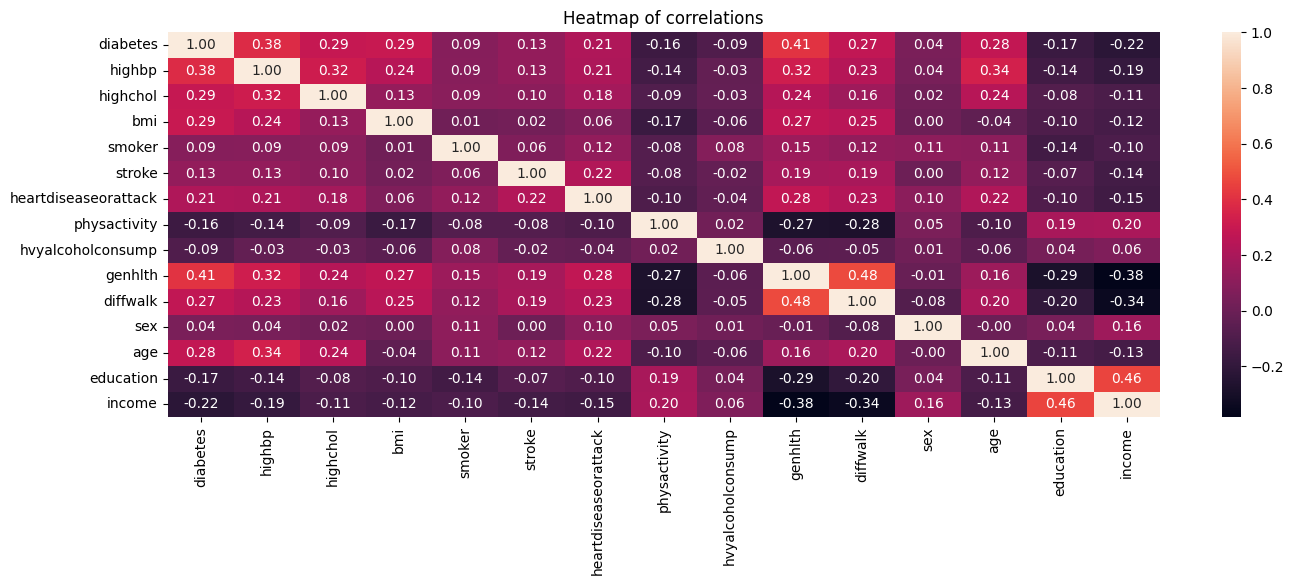

In [125]:
#correlation visualisation
table_dataframe_size = dataframe.size

f, axs = plt.subplots(figsize = [16,5])
correlation = dataframe.corr()
sns.heatmap(correlation, annot= True,fmt= "0.2f" ,ax = axs)
axs.set_title("Heatmap of correlations")

In [126]:
# Training model to predict diabetes
columns = dataframe.columns

columns_without_first = columns[1:]
Y = dataframe["diabetes"].values
X = dataframe[columns_without_first].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 20)


model = Perceptron(max_iter= 15, tol = None, shuffle= True)
model.fit(X_train, Y_train)


Perceptron(max_iter=15, tol=None)

In [127]:
# Function that shows us how correct is our model
def Check_Correctness(table_name):
    dataframe = Create_Dataframe(table_name)
    columns = dataframe.columns
    columns_without_first = columns[1:]
    Y = dataframe["diabetes"].values
    X = dataframe[columns_without_first].values
    
    print(f"score of model: {model.score(X, Y)}")
    dataframe["predicted_value"] = model.predict(dataframe[columns_without_first].values)

    correct = 0; incorrect = 0
    for i in range(len(dataframe)):
        if (float(dataframe["diabetes"].iloc[i]) == float(dataframe["predicted_value"].iloc[i])):
            correct += 1
        else:
            incorrect += 1
            
            
    print(f"amount of correct predictions: {correct}")
    print(f"amount of INcorrect predictions: {incorrect}")


In [130]:
print("Balanced data")
Check_Correctness(table_name= table_name_balanced)

print("\nNot balanced data")
Check_Correctness(talbe_name_not_balanced)

Balanced data
score of model: 0.7338029762915181
amount of correct predictions: 51874
amount of INcorrect predictions: 18818

Not balanced data
score of model: 0.7734547461368654
amount of correct predictions: 196210
amount of INcorrect predictions: 57470
